# Testing DoubleML Package

importing Jupyter notebook from cleaning.ipynb


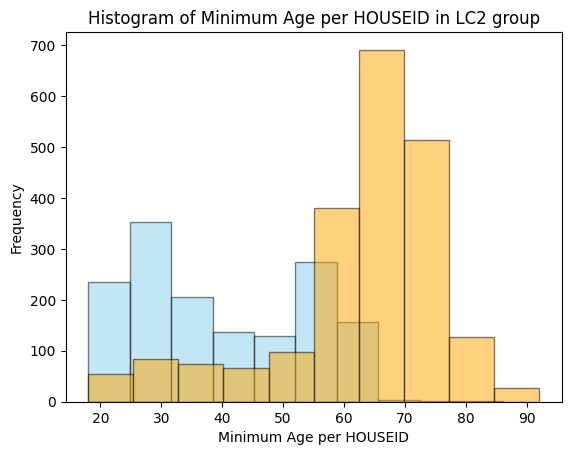

LC2 between 55 and 70 household#: 335
LC10 between 55 and 70 household#: 1159


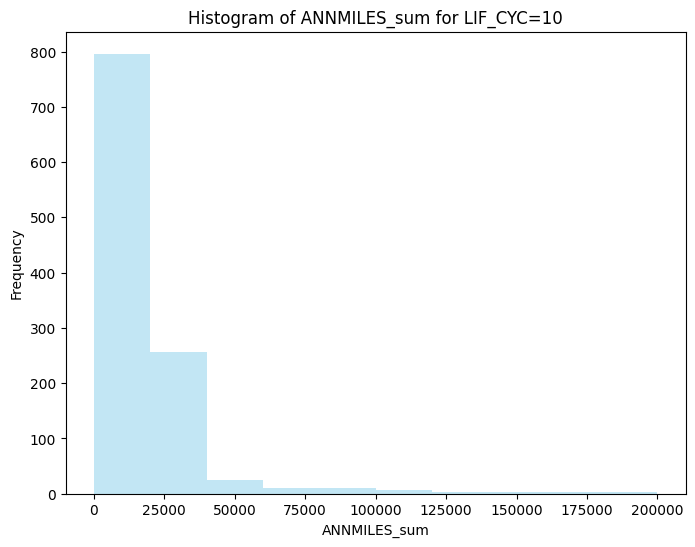

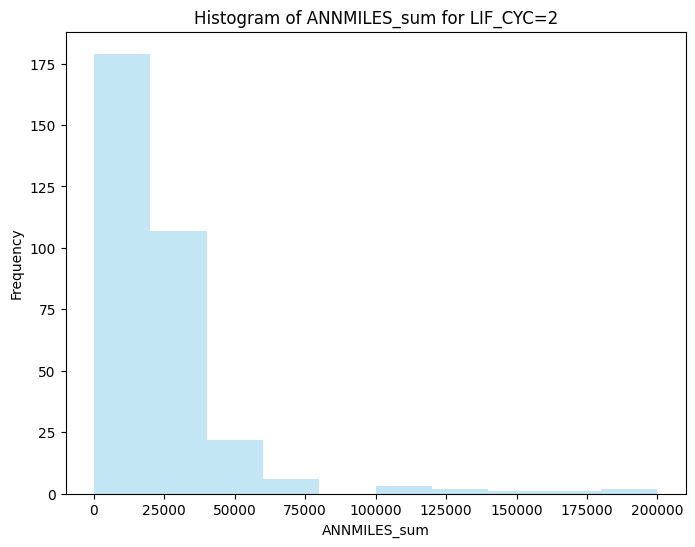

In [1]:
import numpy as np
import import_ipynb
from cleaning import *
from doubleml import DoubleMLData
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm

In [2]:
merged_df = pd.read_csv('final.csv')

In [3]:
cols = merged_df.columns.tolist()
covs = cols[:]
#covs = [x for x in cols if x != 'RETIRE' or x != 'ANNMILES_mean_nonnegative']
covs.remove('RETIRE')
covs.remove('ANNMILES_mean_nonnegative')
covs.remove('PRMACT_-1_PROP')
covs.remove('DRIVINGVEHICLE_-1_PROP')
covs.remove('WRKLOC_-1_PROP')

In [4]:
target = target[target['ANNMILES_sum'].notnull()]
target.loc[target['LIF_CYC'] == 10, 'LIF_CYC'] = 1
target.loc[target['LIF_CYC'] == 2, 'LIF_CYC'] = 0

merged_df['RETIRE'] = np.where(merged_df['RETIRE'], 1, 0)
merged_df['AGE_DUMMY'] = np.where(merged_df['R_AGE_mean_nonnegative'] >= 65, 1, 0)

dml_target = DoubleMLData(merged_df,
                            y_col = 'ANNMILES_mean_nonnegative',
                            d_cols = 'RETIRE',
                            x_cols = covs)

In [5]:
obs = len(merged_df)
vars = 3
theta = 3
X = np.random.normal(size = (obs, vars))
d = np.dot(X[:, :3], np.array([5, 5, 5])) + np.random.standard_normal(size = (obs, ))
y = theta * d + np.dot(X[:, :3], np.array([5, 5, 5])) + np.random.standard_normal(size = (obs,))

In [6]:
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

learner = RandomForestRegressor(n_estimators = obs, max_features = 'sqrt', max_depth = 10)
ml_l_target = clone(learner)
ml_m_target = clone(learner)

learner = LassoCV()
ml_l_sim = clone(learner)
ml_m_sim = clone(learner)

In [7]:
from doubleml import DoubleMLPLR

np.random.seed(20020107)

obj_dml_plr_target = DoubleMLPLR(dml_target, ml_l_target, ml_m_target)
obj_dml_plr_target.fit()
print(obj_dml_plr_target)

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: ANNMILES_mean_nonnegative
Treatment variable(s): ['RETIRE']
Covariates: ['HHFAMINC_IMP', 'HOMETYPE', 'URBRUR_2010', 'CDIVMSAR', 'CENSUS_R', 'DRVRCNT', 'HHSIZE', 'HHVEHCNT', 'HH_HISP', 'HH_RACE', 'HOMEOWN', 'MSACAT', 'MSASIZE', 'RAIL', 'URBAN', 'URBANSIZE', 'URBRUR', 'WRKCOUNT', 'COMMERCIALFREQ_mean_nonnegative', 'VEHAGE_mean', 'EDUC_amin', 'FRSTHM_amin', 'OUTOFTWN_amin', 'EDUC_amax', 'DELIVER_sum_nonnegative', 'DELIV_FOOD_sum_nonnegative', 'DELIV_GOOD_sum_nonnegative', 'DELIV_GROC_sum_nonnegative', 'DELIV_PERS_sum_nonnegative', 'EMPLOYMENT2_mean_nonnegative', 'ESCOOTERUSED_mean_nonnegative', 'GCDWORK_mean_nonnegative', 'MCTRANSIT_mean_nonnegative', 'MEDCOND6_mean_nonnegative', 'PTUSED_mean_nonnegative', 'RIDESHARE22_mean_nonnegative', 'R_AGE_mean_nonnegative', 'TAXISERVICE_mean_nonnegative', 'WALKTRANSIT_mean_nonnegative', 'WKFMHM22_mean_nonnegative', 'CON

In [8]:
formula_controls = "ANNMILES_mean_nonnegative ~ RETIRE + np.subtract(R_AGE_mean_nonnegative, 65) + RETIRE * np.subtract(R_AGE_mean_nonnegative, 65) + " + ' + '.join(covs)
result = sm.ols(formula=formula_controls, data=merged_df).fit()
print(result.summary())

                                OLS Regression Results                               
Dep. Variable:     ANNMILES_mean_nonnegative   R-squared:                       0.116
Model:                                   OLS   Adj. R-squared:                  0.071
Method:                        Least Squares   F-statistic:                     2.549
Date:                       Wed, 28 Feb 2024   Prob (F-statistic):           3.34e-16
Time:                               12:40:42   Log-Likelihood:                -26662.
No. Observations:                       2363   AIC:                         5.356e+04
Df Residuals:                           2246   BIC:                         5.423e+04
Df Model:                                116                                         
Covariance Type:                   nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [20]:
### Running two-stage Fuzzy RDD

# Create training and testing data
train, test = train_test_split(
    merged_df, test_size = 0.33)

# First Stage
formula_first_stage = "RETIRE ~ AGE_DUMMY + np.subtract(R_AGE_mean_nonnegative, 65)  + " + ' + '.join(covs)
result_first_stage = sm.ols(formula = formula_first_stage, data = train).fit()

In [21]:
# Second Stage
test['ESTIMATED_TREATMENT'] = result_first_stage.predict(test)
formula_second_stage = "ANNMILES_mean_nonnegative ~ ESTIMATED_TREATMENT + np.subtract(R_AGE_mean_nonnegative, 65)  + " + ' + '.join(covs)
result_second_stage = sm.ols(formula = formula_second_stage, data = test).fit()
print(result_second_stage.summary())

                                OLS Regression Results                               
Dep. Variable:     ANNMILES_mean_nonnegative   R-squared:                       0.231
Model:                                   OLS   Adj. R-squared:                  0.099
Method:                        Least Squares   F-statistic:                     1.748
Date:                       Wed, 28 Feb 2024   Prob (F-statistic):           1.43e-05
Time:                               12:42:43   Log-Likelihood:                -8643.2
No. Observations:                        780   AIC:                         1.752e+04
Df Residuals:                            665   BIC:                         1.805e+04
Df Model:                                114                                         
Covariance Type:                   nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------